In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import os
import tensorflow as tf
import requests, zipfile, io,shutil
from keras.models import Sequential,Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,f1_score,accuracy_score

%matplotlib inline

In [13]:
# setting the target height and width of the images to be one of the sizes used in mobilenet.
im_height = 224
im_width = 224

In [14]:
# Download the images
filepath = 'sushi_or_sandwich'
url = 'http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip'
if not os.path.exists(filepath):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

In [15]:
def get_path():
    sndwch_path = 'sushi_or_sandwich/sandwich/'
    sushi_path = 'sushi_or_sandwich/sushi/'
    sandwich = os.listdir(sndwch_path)
    sushi = os.listdir(sushi_path)

    i=0
    for elem in sandwich:
        sandwich[i] = sndwch_path+elem
        i+=1
    i=0
    for elem in sushi:
        sushi[i] = sushi_path+elem
        i+=1

    return np.array(sandwich),np.array(sushi)

sandwich,sushi = get_path()

In [16]:
tf.InteractiveSession()

In [28]:
## Resizing and cropping sandwich images
i=0
for img in sandwich:
    j=0
    temp = plt.imread(img)
    if temp.shape[0]>500 and temp.shape[1]>500:
        for j in range(1,4):
            plt.imsave(f'sushi_or_sandwich/sandwich/{i}-{j}.jpg',tf.random_crop(temp,[im_height,im_width,3]).eval())
    i+=1
    if i%20==0:
        print(f'{i} images cropped')

In [27]:
# Resizing and cropping sushi images
i=0
for img in sushi:
    j=0
    temp = plt.imread(img)
    if temp.shape[0]>500 and temp.shape[1]>500:
        for j in range(1,4):
            plt.imsave(f'sushi_or_sandwich/sushi/{i}-{j}.jpg',tf.random_crop(temp,[im_height,im_width,3]).eval())
    i+=1
    if i%20==0:
        print(f'{i} images cropped')

In [19]:
sandwich,sushi = get_path()

In [20]:
# Creating the folder structure for keras Image data generator.
lst = ['train','test','val']
categories = ['sushi','sandwich']
if not os.path.exists('data'):
    os.makedirs('data')
for name in lst:
    if not os.path.exists(f'data/{name}'):
        os.makedirs(f'data/{name}')
    for elem in categories:
        if not os.path.exists(f'data/{name}/{elem}'):
            os.makedirs(f'data/{name}/{elem}')

In [22]:
# randomly choosing files to put in train,test and validation folders
path_var = {}
path_var['train_sandwich'] = np.random.choice(sandwich,int(0.8*len(sandwich)),replace=False)
temp = np.setdiff1d(sandwich,path_var['train_sandwich'])
path_var['val_sandwich'] = np.random.choice(temp,int(0.6*len(temp)),replace=False)
path_var['test_sandwich'] = np.setdiff1d(temp,path_var['val_sandwich'])

path_var['train_sushi'] = np.random.choice(sushi,int(0.8*len(sushi)),replace=False)
temp = np.setdiff1d(sushi,path_var['train_sushi'])
path_var['val_sushi'] = np.random.choice(temp,int(0.6*len(temp)),replace=False)
path_var['test_sushi'] = np.setdiff1d(temp,path_var['val_sushi'])

# moving files to the relevant folders
for key,values in path_var.items():
    a,b = key.split('_')
    destination = f'data/{a}/{b}/'
    for image_path in values:
        shutil.copyfile(image_path,destination+image_path.split('/')[-1])

After trying different models including custom,inception,mobilenet,resnet and inception-resnet I got the best generalisation with inception-resnet. So I've only included inception-resnet here.

In [23]:
"""Created this data structure - 
        data/
                train/
                        sandwich/
                        sushi/
                val/
                        sandwich/
                        sushi/
                test/
                        sandwich/
                        sushi/
                        
This lets us take advantage of keras flow_from_directory function with ImageDataGenerator to directly load images and 
apply data augmentation with just a line of code.
                        """;

All images are of differnt shapes so we'll have to resize all images to single size. I'll choose to downsample the bigger images than to upsample the smaller images so as not to add extra random noise in the system. So I'm going to resize every image to 299 by 299 square shaped image and also take random crops out of bigger images for data augmentation. This is going to make our dataset larger and hopefully provide robustness against prediction of badly taken images.

In [24]:
#create training, validation and test generators 
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip = True,
                                  shear_range=0.2,
                                   zoom_range=0.2,
                                  rotation_range=30)

train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   target_size = (im_height,im_width),
                                                   class_mode = 'binary',
                                                   shuffle = False)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(directory='data/val',
                                                color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   target_size = (im_height,im_width),
                                                   class_mode = 'binary',
                                                 shuffle=False)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory='data/test',
                                                  color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   target_size = (im_height,im_width),
                                                   class_mode = 'binary',
                                                  shuffle=False)







Found 1802 images belonging to 2 classes.
Found 270 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [26]:
base_model = MobileNet(weights='imagenet',include_top=False,input_shape=(im_height,im_width,3))

In [29]:
# Freeze all the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

To speedup the slow learning due to depth of mobilenet we're going to save the activation maps for the training and validation data just before the fully connected layer. This works because we're freezing all the layers of mobilenet which means the weights below the fully connected layers are not going to change. This implies we'll be repeating the same calulations for the bottom layers again and again, every epoch, which is computationally expensive and useless.
Therefore we'll save the activation maps for the bottom layers and just train the fully connected layer on top of it. If this doesn't give good accuracy and generalization, we'll slowly unfreeze the bottom layers sequentially from the top. This is to finetune the model based on our image dataset.

In [32]:
train_generator.samples

1802

In [33]:
# Check to save time if the bottleneck features already exists.
if 'bottleneck_features_train.npy' not in os.listdir():
    bottleneck_features_train = base_model.predict_generator(train_generator,np.ceil(train_generator.samples/batch_size))
    np.save('bottleneck_features_train.npy',bottleneck_features_train)

if 'bottleneck_features_val.npy' not in os.listdir():
    bottleneck_features_val = base_model.predict_generator(val_generator,np.ceil(val_generator.samples/batch_size))
    np.save('bottleneck_features_val.npy',bottleneck_features_val)

if 'bottleneck_features_test.npy' not in os.listdir():
    bottleneck_features_test = base_model.predict_generator(test_generator,np.ceil(test_generator.samples/batch_size))
    np.save('bottleneck_features_test.npy',bottleneck_features_test)

In [34]:
# Loading the bottleneck features. These features will be used as the training and validation data 
# instead of raw pixels of the image.
train_data = np.load('bottleneck_features_train.npy')
train_labels = train_generator.classes

val_data = np.load('bottleneck_features_val.npy')
val_labels = val_generator.classes


In [35]:
# architecture of mobilenet. We've excluded the top fully connected part as we'll customise that to our case.
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [36]:
# Fully connected top layer to make predictions.
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
# model.add(Dense(64,activation='relu'))   # No real improvement due to this layer so ignoring it
model.add(Dropout(0.5)) # Aggresive regularisation
model.add(Dense(1,activation='sigmoid')) 


In [37]:
# Defining the weights update rule.

# model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'], optimizer = 'adam')

"""From training puposes ADAM cnverges to the soluton really quickly which is good.
But to make decent looking plot we'll change this to rmsprop so that we can acually see the
model learning to classify the images i.e loss decreasing slowly. We can do this becuase in this case it's not computationally
expensive to run rms over adam. they both take approx. 40-50 seconds."""

rmsprop  = optimizers.RMSprop(lr=0.00001,decay=0.0, rho=0.9)
model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'], optimizer = rmsprop)

In [38]:
# fit the model.
if 'best.npy' not in os.listdir():
    check_point = ModelCheckpoint('best.npy', monitor='val_acc', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='auto', period=1)
    
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=1, mode='auto')
    
    model_history = model.fit(train_data,train_labels,
          epochs=300,
         batch_size = batch_size,
           shuffle=True,
         validation_data = (val_data,val_labels),
          callbacks = [check_point,early_stopping])
    pd.DataFrame(model_history.history).to_csv('model-history.csv')

else:
    model.load_weights('best.npy')
model.load_weights('best.npy')   
model_history = pd.read_csv('model-history.csv')

Train on 1802 samples, validate on 270 samples
Epoch 1/300
1802/1802 [==============================] - 101s 56ms/step - loss: 1.2307 - acc: 0.5416 - val_loss: 0.8693 - val_acc: 0.6370
Epoch 2/300
1802/1802 [==============================] - 2s 1ms/step - loss: 1.1165 - acc: 0.5866 - val_loss: 0.6965 - val_acc: 0.7074
Epoch 3/300
1802/1802 [==============================] - 2s 989us/step - loss: 0.9125 - acc: 0.6659 - val_loss: 0.6256 - val_acc: 0.7259
Epoch 4/300
1802/1802 [==============================] - 2s 1ms/step - loss: 0.8356 - acc: 0.6909 - val_loss: 0.5634 - val_acc: 0.7370
Epoch 5/300
1802/1802 [==============================] - 2s 1ms/step - loss: 0.7472 - acc: 0.7014 - val_loss: 0.5398 - val_acc: 0.7593
Epoch 6/300
1802/1802 [==============================] - 2s 968us/step - loss: 0.7006 - acc: 0.7236 - val_loss: 0.4934 - val_acc: 0.7778
Epoch 7/300
1802/1802 [==============================] - 2s 1ms/step - loss: 0.6854 - acc: 0.7436 - val_loss: 0.4928 - val_acc: 0.7926
E

1802/1802 [==============================] - 1s 750us/step - loss: 0.0607 - acc: 0.9789 - val_loss: 0.3383 - val_acc: 0.8667
Epoch 61/300
1802/1802 [==============================] - 1s 734us/step - loss: 0.0729 - acc: 0.9756 - val_loss: 0.3346 - val_acc: 0.8741
Epoch 62/300
1802/1802 [==============================] - 1s 721us/step - loss: 0.0658 - acc: 0.9795 - val_loss: 0.3524 - val_acc: 0.8630
Epoch 63/300
1802/1802 [==============================] - 1s 721us/step - loss: 0.0598 - acc: 0.9806 - val_loss: 0.3416 - val_acc: 0.8630
Epoch 64/300
1802/1802 [==============================] - 1s 729us/step - loss: 0.0506 - acc: 0.9856 - val_loss: 0.3478 - val_acc: 0.8630
Epoch 65/300
1802/1802 [==============================] - 1s 719us/step - loss: 0.0640 - acc: 0.9767 - val_loss: 0.3410 - val_acc: 0.8704
Epoch 66/300
1802/1802 [==============================] - 1s 796us/step - loss: 0.0474 - acc: 0.9883 - val_loss: 0.3403 - val_acc: 0.8778
Epoch 67/300
1802/1802 [=======================

1802/1802 [==============================] - 1s 791us/step - loss: 0.0138 - acc: 0.9983 - val_loss: 0.3663 - val_acc: 0.8815
Epoch 120/300
1802/1802 [==============================] - 1s 789us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.3651 - val_acc: 0.8815
Epoch 121/300
1802/1802 [==============================] - 1s 789us/step - loss: 0.0086 - acc: 0.9989 - val_loss: 0.3642 - val_acc: 0.8889
Epoch 122/300
1802/1802 [==============================] - 1s 803us/step - loss: 0.0097 - acc: 0.9994 - val_loss: 0.3640 - val_acc: 0.8889
Epoch 123/300
1802/1802 [==============================] - 1s 825us/step - loss: 0.0119 - acc: 0.9972 - val_loss: 0.3669 - val_acc: 0.8852
Epoch 124/300
1802/1802 [==============================] - 2s 980us/step - loss: 0.0093 - acc: 0.9989 - val_loss: 0.3777 - val_acc: 0.8704
Epoch 125/300
1802/1802 [==============================] - 2s 1ms/step - loss: 0.0084 - acc: 0.9989 - val_loss: 0.3695 - val_acc: 0.8926
Epoch 126/300
1802/1802 [==================

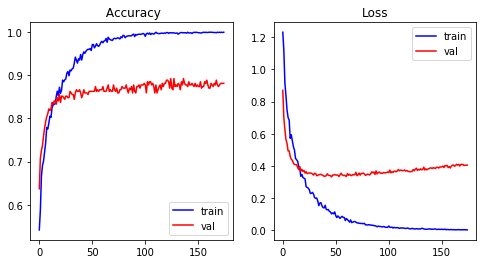

In [39]:
# plotting training and validation loss and accuracy per epoch.
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(model_history['acc'],'blue')
plt.plot(model_history['val_acc'],'red')
plt.title(' Accuracy')
plt.legend(['train','val'])

plt.subplot(1,2,2)
plt.plot( model_history['loss'],'blue')
plt.plot(model_history['val_loss'],'red')
plt.title('Loss')
plt.legend(['train','val'])

# Test set predictions

In [40]:
# loading the bottleneck featurs of test data
test_data = np.load('bottleneck_features_test.npy')
test_labels = test_generator.classes

In [41]:
pred = model.predict(test_data,2).ravel()
pred_round = np.round(pred)

# Different metrices for checking the model performance and interpretation

In [42]:
cm = confusion_matrix(test_generator.classes,pred_round)
cm

array([[101,   9],
       [ 13,  59]])

In [44]:
f1score = f1_score(test_generator.classes,pred_round)
auc = roc_auc_score(test_generator.classes,pred)
acc = accuracy_score(test_generator.classes,pred_round)
print('f1-score of the model-----',f1score)
print('auc-score of the model-----',auc)
print('accuracy-score of the model-----',acc)

f1-score of the model----- 0.842857142857
auc-score of the model----- 0.932702020202
accuracy-score of the model----- 0.879120879121


These scores imply that our system is generalising well. High f1_score means both precision and recall are high which is good. Since this is a balanced dataset, we expected to have a balanced prediction which is visible from the confusion matrix. Number of false positive and 
false negatves are almost same. This means our model is not biased towards one particular class.

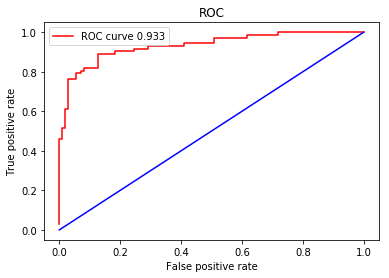

In [45]:
# ROC curve for the results.
fpr,tpr,thresholds = roc_curve(test_generator.classes,pred)
plt.plot(fpr, tpr,'red', label=f'ROC curve {auc:0.3f}')
plt.plot([0, 1], [0, 1],'blue')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend()

In [46]:
# Next we'll build a real time classifier by combining mobilenet and the fully connected top model.
# This will take any image as input and predict the class. No need to save the activations befoehand for test images.

In [47]:
full_model = Model(inputs=base_model.input, outputs=model(base_model.output))
full_model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'], optimizer = 'adam')
# we're using adam optimizer here for fast training

In [48]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [51]:
len(test_generator)

10

In [50]:
images,labels = test_generator[0]
for i in range(1,len(test_generator)):
    images = np.concatenate([images,test_generator[i][0]])
    labels = np.concatenate([labels,test_generator[i][1]])

In [52]:
pred = full_model.predict_generator(test_generator).ravel()
misclassified = np.where(np.round(pred)!=labels)[0]

Below we show all the misclassified images in the test set.

{'sandwich': 0, 'sushi': 1}
*****************************************ALL MISCLASSIFIED IMAGES*********************************************


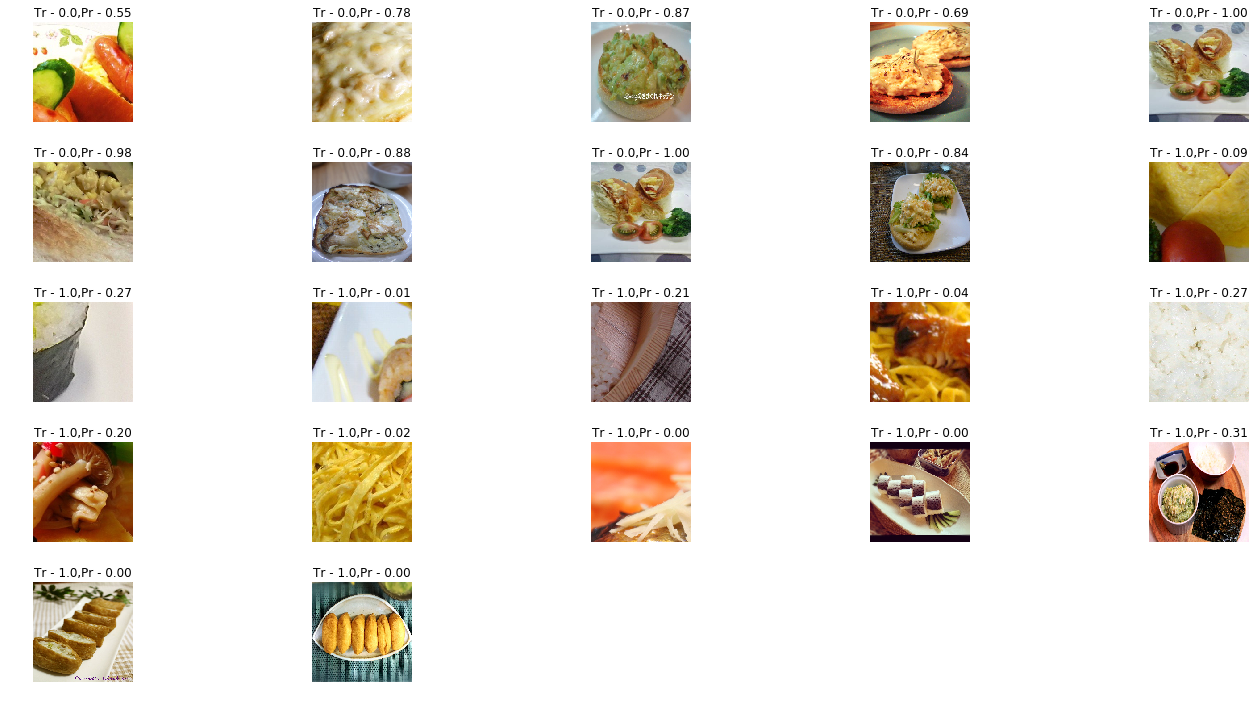

In [53]:
plt.figure(figsize=[25,25])
gs = GridSpec(10,5)
gs.update(wspace=0.00005, hspace=0.4)
print(test_generator.class_indices)
print('*****************************************ALL MISCLASSIFIED IMAGES*********************************************')
j=0
for i in misclassified:
    plt.subplot(gs[j])
    j+=1
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Tr - {labels[i]},Pr - {pred[i]:.2f}')

We can see that most of the wrong classification are actually quite difficult even for human and some are not even sushi or sandwich(pics of plate,spoon,laddle, bowl,sauce etc). 
This is due to random cropping that lead to background images in the dataset (plate,boowl,spoon etc.) as well as badly taken images that contains only the fillings etc.
Ignoring such images,  our model perform exceptioanlly well on sushi/sandwich classification. 
e.g in the above 42 misclassified images approx. 9 images doesn't have sushi or sandwich on the pic. This means our misclassified images are actually 13 only. This means the accuracy score is approx. (101+59)/(182-13) = **94.67%**

 Below we show the prediction on some images in general.

{'sandwich': 0, 'sushi': 1}


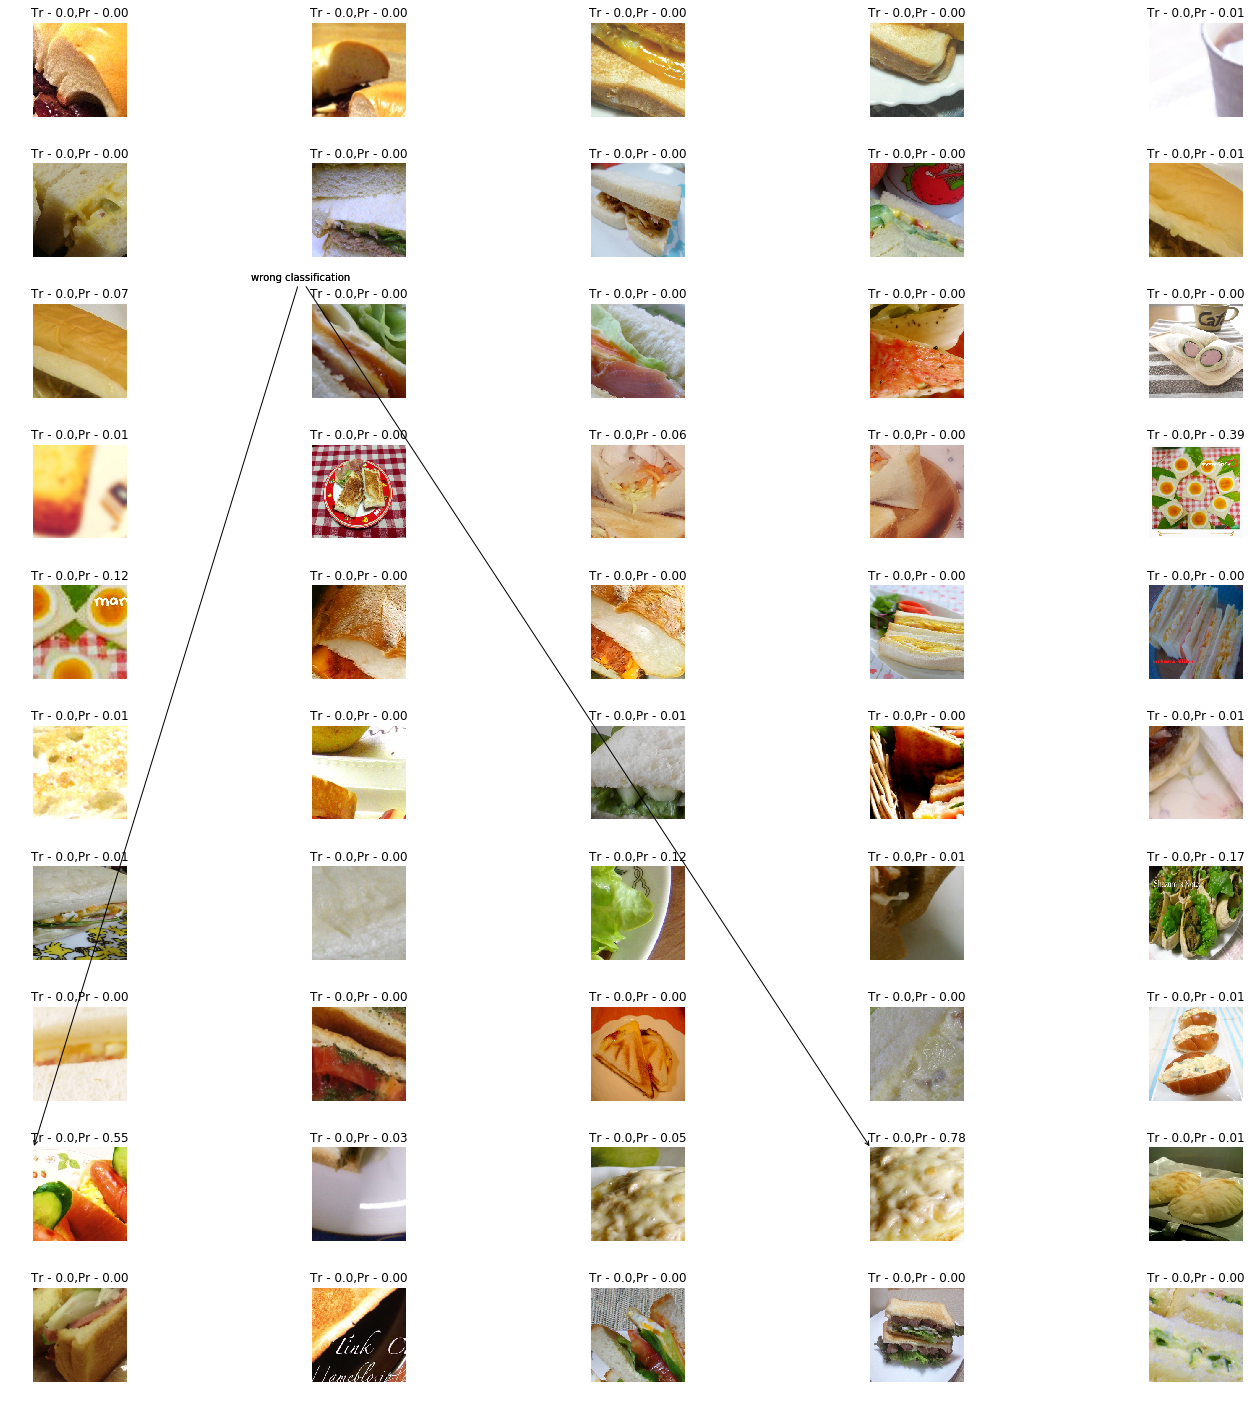

In [55]:
plt.figure(figsize=[25,25])
gs = GridSpec(10,5)
gs.update(wspace=0.0005, hspace=0.5)
print(test_generator.class_indices)
for i in range(50):
#     pred = full_model.predict(images[i].reshape(1,im_height,im_width,3)).ravel()[0]
    plt.subplot(gs[i])
    plt.imshow(images[i],)
    plt.axis('off')
    plt.title(f'Tr - {labels[i]},Pr - {pred[i]:.2f}')
    if labels[i]!=np.round(pred[i]):
        plt.annotate('wrong classification', xy=(0.5,0.5), xycoords='data',
             xytext=(0.2, 0.8), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))